## **Solutions to Week 12 Recitation Problems** 

”The goal of a model is not to uncover truth, but to discover a simple approximation that is still useful.” Today we will use the techniques from Chapter 23 to model bid price in foreclosure auctions in California. When a property is foreclosed on, the lender auctions the property in a ’foreclosure auction’ open to the public in order to recuperate the lost funds. Recently the DOJ broke up a cartel that had formed in the foreclosure auction market in California where the colluding parties would ”pre-auction” the properties among themselves and then artificially lower the bidding price (by not competing with each other). This dataset contains information on properties sold in these foreclosure auctions during the time period of the cartel - the variable ”CartelCompany” indicates if the buyer was one of the companies prosecuted by the DOJ.

First things first I will import the libraries that I will need today. I will need ```tidyverse``` for importing, cleaning, and plotting and I may potentially need ```modelr``` for any advanced modeling. Lastly I may need ```lubridate``` incase I need to work with cleaning dates and times.

In [3]:
library(tidyverse)
library(modelr)
library(lubridate)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



Next I will read in the data and begin to take a look at whats in there. For basic data investigation I would want to find a list of variables included in the dataset as well as number of levels in each categorical varaible and max/min and mean for continuous variables.

In [4]:
readin = "<filepath>/California Foreclosure Auctions.csv"
auctions = read_csv(readin)

Parsed with column specification:
cols(
  .default = col_double(),
  RadarID = col_character(),
  County = col_character(),
  Address = col_character(),
  City = col_character(),
  State = col_character(),
  Owner = col_character(),
  OwnerFirstName = col_character(),
  OwnerLastName = col_character(),
  PropertyType = col_character(),
  FirstLoanLender = col_character(),
  TransferDate = col_character(),
  TransferBuyer = col_character(),
  TransferSeller = col_character(),
  TransferDownPaymentPercent = col_logical()
)
See spec(...) for full column specifications.


In [12]:
glimpse(auctions)     #list of variables and types - same as str(auctions) but without extra information
count(auctions, County)
summary(auctions$TransferAmount)

Observations: 10,061
Variables: 29
$ RadarID                    <chr> "P10B875B", "P10C21B8", "P118636F", "P119F…
$ County                     <chr> "SAN JOAQUIN", "SAN JOAQUIN", "SAN MATEO",…
$ Address                    <chr> "4315 LEGACY CT", "2126 BARTRAM RUN WAY", …
$ City                       <chr> "STOCKTON", "STOCKTON", "DALY CITY", "STOC…
$ State                      <chr> "CA", "CA", "CA", "CA", "CA", "CA", "CA", …
$ Zip                        <dbl> 95219, 95212, 94015, 95212, 94521, 95212, …
$ Owner                      <chr> "MAGALI,MYLO C & CHARIS", "REYNOLDS,CLAUDE…
$ OwnerFirstName             <chr> "MYLO", "CLAUDE", "MARK", "XUGUANG", "EDIT…
$ OwnerLastName              <chr> "MAGALI", "REYNOLDS", "TARAKANOV", "YANG",…
$ PropertyType               <chr> "SFR", "SFR", "SFR", "SFR", "SFR", "SFR", …
$ Units                      <dbl> 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ SqFt                       <dbl> 1408, 2452, 1900, 2398, 1308, 2632, 1371, …
$ YearBuilt      

County,n
ALAMEDA,2443
CONTRA COSTA,3252
SAN FRANCISCO,150
SAN JOAQUIN,3417
SAN MATEO,799


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0  108285  181100  225191  293438 3066001       1 

Cool, there are 10,061 observations (properties auctioned) in 5 counties around San Fransisco. The properties are not evently distributed among the counties. The final auction prices ```TransferAmount``` range from \\$0.00 to \\$3,066,001.00 but with an average price of \\$225,191.00. Thats a pretty big range, and it seems odd that some houses went for free while there was at least one 3 million dollar house that was foreclosed on. 

## 1) What is a family of equations? Write down two different examples of a family of equations you might use in a linear regression model. What are the key differences between the two families you wrote down in terms of your data and model?

From section 23.1, a family of equations or models is a set of equations that all have the same form but can have any value as the parameters. For example $y = mx + b$ is the general family of linear equations: $y$ is one variable and $x$ is the other and they are related by a slope $m$ and intercept $b$, the parameters. Changing $m$ and $b$ will produce a different equation (a line with different slope and intercept) but it will have the same form (ie it will still be a line). Therefore these are all said to be of the same "family" just with different parameters. Similarly, another example is $y=ax^2+bx+c$ is the general family of quadratic equations: $y$ is one varaible and $x$ the other and there are now three parameters $a$, $b$, and $c$. Changing these parameters will produce a different parabola but it will always be a parabola. 

When specifying regression models, we first specify a family of models, and then we let the regression determine the parameters. So we say, "fit a line" and the regression determines which exact line from the family of lines fits the data the best and then tells you what the value of the parameters are that determine that specific line. For example, if I want to predict $y$ using $x_1$ then I would specify the family of models: $y = \beta_0 + \beta_1x_1$ where $\beta_0$ is the intercept parameter and $\beta_1$ is the slope parameter for the varaible $x_1$.

If I wanted to specify a multiple linear regression I would specify the family of models $y = \beta_0 + \beta_1x_1 + \beta_2x_2$ and the regression would give me the values of the parameters that best fit the data (if you're interested, this actually defines a surface in 3D where the slope parameters $\beta_1$ and $\beta_2$ represent the slope in the respective $x_1$ and $x_2$ directions). 

## 2) Pick one variable to predict auction price and fit a simple linear model with the following equation: $\hat{y} = \beta_0 +\beta_1x_1$. Following the techniques of 23.2 and 23.3 in the textbook, plot a freqpoly of your residuals, and plot your residuals against your predictor variable - was your model a good fit? argue based on both plots. ##

I will use EstimatedValue to predict TransferAmount. I picked EstimatedValue because it seemed interesting, but you can pick any variable you want. I am specifying the model  
  
$TransferAmount = \beta_0 + \beta_1*EstimatedValue$  
  
and I want to know what parameteres make this line the closes fit to my data.

In [15]:
m1 <- lm(TransferAmount ~ EstimatedValue, data = auctions)
m1


Call:
lm(formula = TransferAmount ~ EstimatedValue, data = auctions)

Coefficients:
   (Intercept)  EstimatedValue  
    -1.950e+04       4.689e-01  


Cool, the regression told me the value of the intercept parameter is -19,500.00 and the value of the slope parameter is 0.4689 to best fit my data to the line. Lets visualize this.

Warning message:
“Removed 1 rows containing missing values (geom_point).”

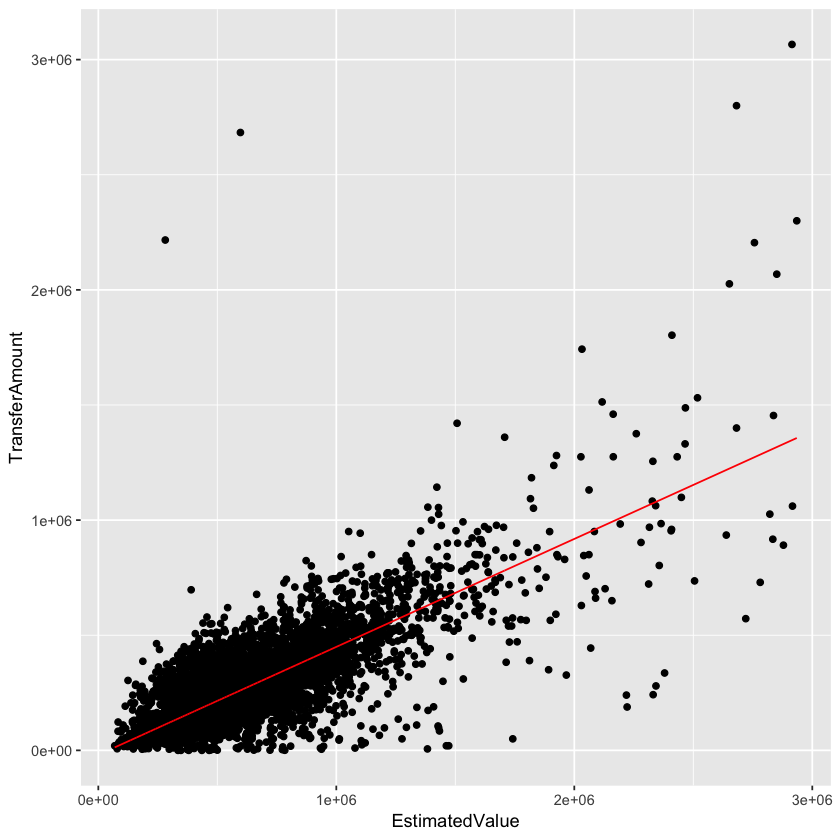

In [18]:
grid <- auctions %>% data_grid(EstimatedValue) %>% add_predictions(m1)   #from section 23.3 we can add our best fit line to a scatter plot of our data

ggplot() + geom_point(data = auctions, aes(x = EstimatedValue, y = TransferAmount)) +   
    geom_line(data = grid, aes(x = EstimatedValue, y = pred), col = "red")

Awesome, this looks like a really well fit line. The line represents the best guess - based on the data - of how much a property will go for at auction if we are given its estimated value. Now we can examine the residuals (see section 23.3) to get a sense of how well the line can predict the actual values.

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”

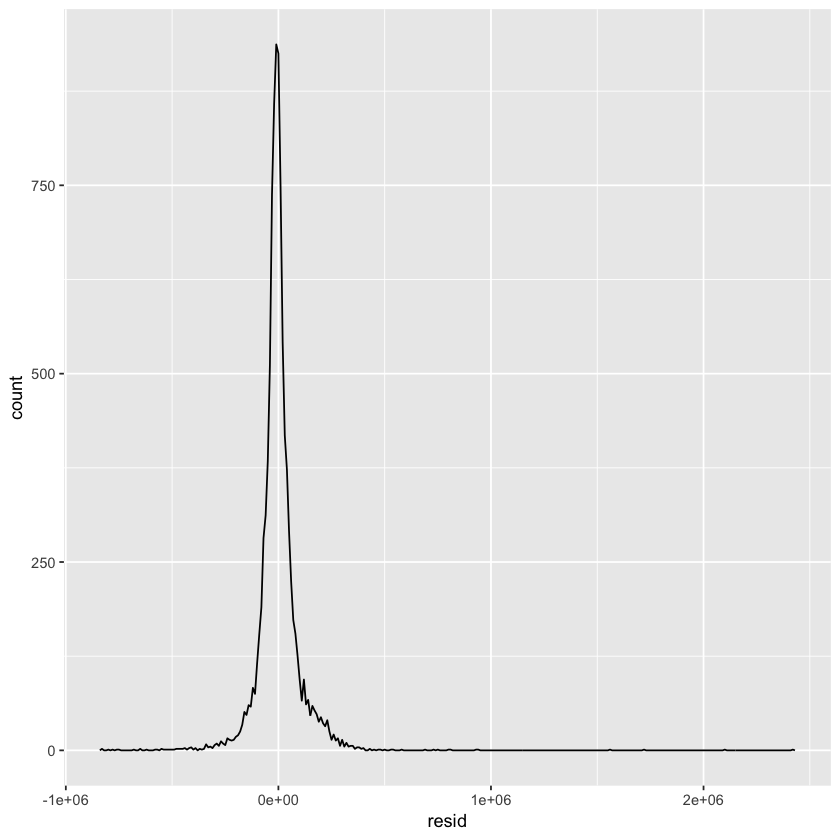

In [19]:
auctions_resid <- auctions %>% add_residuals(m1)       # add the residual values to each observation in the dataset (resid = y - y_hat)
ggplot(auctions_resid) + geom_freqpoly(aes(resid),binwidth=10000)

Great, the residuals are centered around zero which checks out. Interestingly, they are pretty tightly centered around zero which means most of our predictions were decent (it looks like the vast majoritiy were within +/- \\$250,000.00. But interestingly there were at least a few that were more than 2 million dollars off.

Next we can get a sense of if there is any bias in our model by examining the residuals more closely. If we plot them against the predictor variable we can see if the prediction is systematically off (i.e. are our predictions systematically worse for certain values of the predictor variable).

Warning message:
“Removed 1 rows containing missing values (geom_point).”

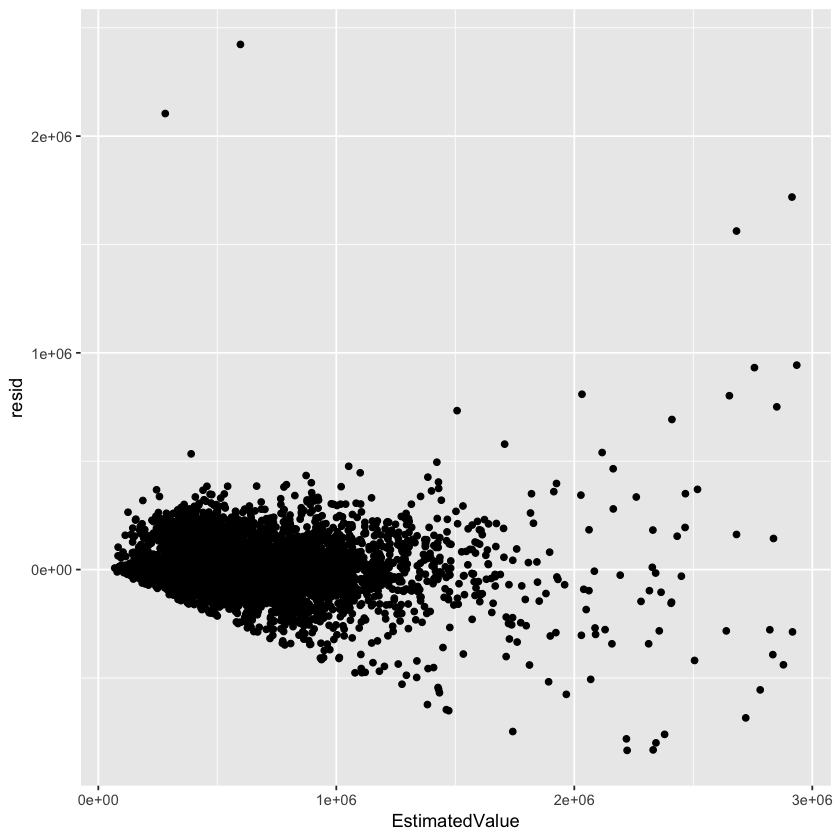

In [20]:
ggplot(auctions_resid) + geom_point(aes(EstimatedValue,resid))

It looks like there is some bias in our predictions. First of all, its good to note that the couple properties where our prediction was almost 3 million dollars off were properties that were estimated to be much lower value (around 400k to 600k). Also, there is a pretty clear pattern here: the higher the estimated value the more variable the prediction accuracy. This indicates there are likely other variables affecting ```TransferAmount``` than just ```EstimatedValue``` and we should add variables to our model.